### Data source

https://www.kaggle.com/datasets/camnugent/california-housing-prices


1. longitude: A measure of how far west a house is; a higher value is farther west
2. latitude: A measure of how far north a house is; a higher value is farther north
3. housingMedianAge: Median age of a house within a block; a lower number is a newer building
4. totalRooms: Total number of rooms within a block
5. totalBedrooms: Total number of bedrooms within a block
6. population: Total number of people residing within a block
7. households: Total number of households, a group of people residing within a home unit, for a block
8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. medianHouseValue: Median house value for households within a block (measured in US Dollars)
10. oceanProximity: Location of the house w.r.t ocean/sea

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
df = pd.read_csv('housing.csv')

In [21]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


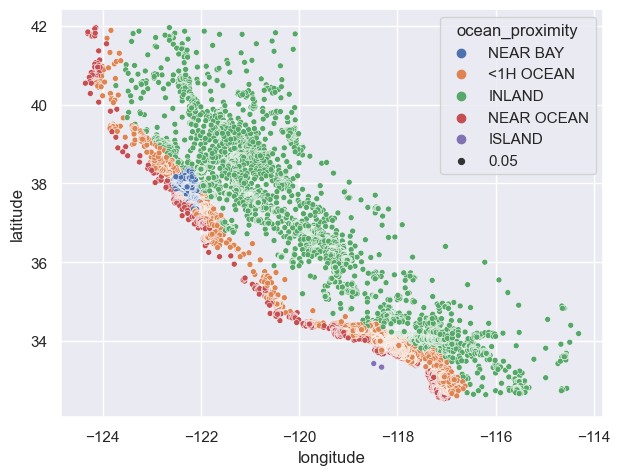

In [51]:
sns.set(rc={'figure.figsize':(7,5.3)})
sns.scatterplot(data=df, x='longitude', y='latitude', size=0.05, hue='ocean_proximity')
plt.show()

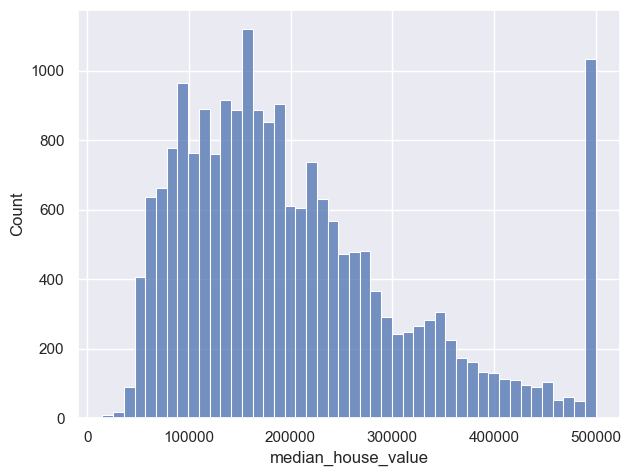

In [64]:
sns.histplot(data=df, x='median_house_value')
plt.show()

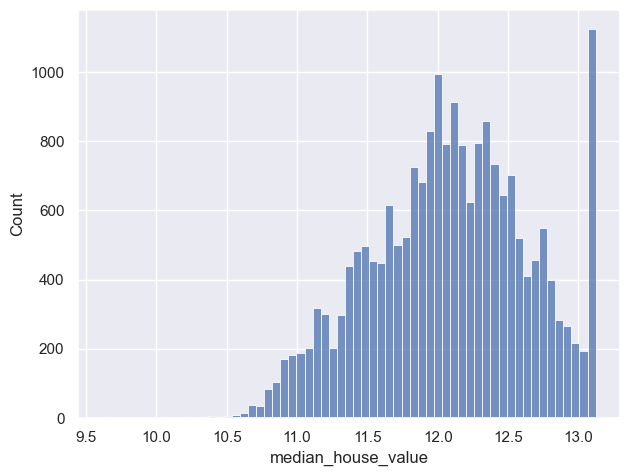

In [65]:
sns.histplot(np.log1p(df.median_house_value))
plt.show()

##### Look at the median_house_value variable. Does it have a long tail?
* Yes

In [42]:
df.ocean_proximity.unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [109]:
cols = ['latitude',
'longitude',
'housing_median_age',
'total_rooms',
'total_bedrooms',
'population',
'households',
'median_income',
'median_house_value']
X_col = ['latitude',
'longitude',
'housing_median_age',
'total_rooms',
'total_bedrooms',
'population',
'households',
'median_income']

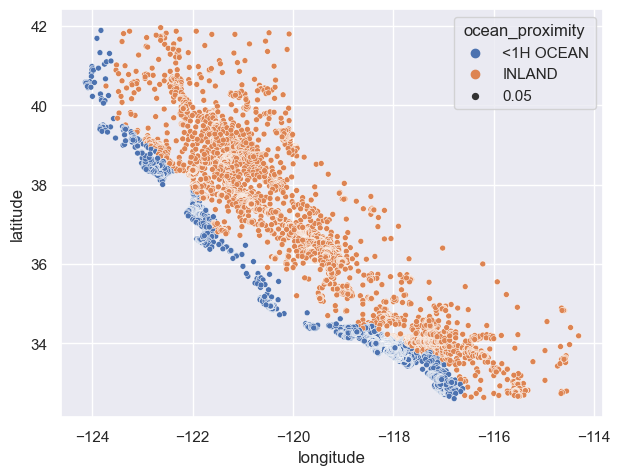

In [204]:
sns.set(rc={'figure.figsize':(7,5.3)})
sns.scatterplot(data=df[(df.ocean_proximity == '<1H OCEAN') | (df.ocean_proximity == 'INLAND')], x='longitude', y='latitude', size=0.05, hue='ocean_proximity')
plt.show()

In [55]:
df_small = df[(df.ocean_proximity == '<1H OCEAN') | (df.ocean_proximity == 'INLAND')][cols]

In [56]:
df_small.columns == cols

array([ True,  True,  True,  True,  True,  True,  True,  True,  True])

In [57]:
df_small.isna().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

##### There's one feature with missing values. What is it?
* total_bedrooms

##### What's the median (50% percentile) for variable 'population'?

In [61]:
df_small.population.median()

1195.0

### Prepare and split

In [93]:
n = len(df_small)
n_val = int(n*.2)
n_test = int(n*.2)
n_train = n - n_val - n_test
n, n_train, n_val, n_test

(15687, 9413, 3137, 3137)

In [94]:
np.random.seed(42)
index_rand = np.arange(n)
np.random.shuffle(index_rand)
index_rand

array([15183,  4469,  9316, ...,  5390,   860,  7270])

In [95]:
df_train = df_small.iloc[index_rand[:n_train]]
df_val = df_small.iloc[index_rand[n_train:n_train+n_val]]
df_test = df_small.iloc[index_rand[n_train+n_val:]]

n, len(df_train), len(df_val), len(df_test)

(15687, 9413, 3137, 3137)

In [96]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [122]:
def prepare_data(df_local: pd.DataFrame, replace_val=0):
    df_local = df_local.copy()
    df_local['total_bedrooms'] = df_local['total_bedrooms'].fillna(0)
    y_local = np.log1p(df_local['median_house_value'])
    X_local = df_local[X_col]
    return X_local, y_local

In [128]:
X_train_0, y_train_0 = prepare_data(df_train)
X_val_0, y_val_0 = prepare_data(df_val)
X_test_0, y_test_0 = prepare_data(df_test)

In [154]:
X_train_m, y_train_m = prepare_data(df_train, df['total_bedrooms'].mean())
X_val_m, y_val_m = prepare_data(df_val, df['total_bedrooms'].mean())
X_test_m, y_test_m = prepare_data(df_test, df['total_bedrooms'].mean())

In [156]:
X_train_0['total_bedrooms'].mean()

537.1349197917773

In [153]:
X_train_m['total_bedrooms'].mean()

537.1349197917773

In [141]:
df_train['total_bedrooms'].mean(numeric_only=True, skipna=False), df_train['total_bedrooms'].isna().sum(), len(df_train)

(nan, 94, 9413)

In [150]:
df_train['total_bedrooms'].sum()/(len(df_train) - df_train['total_bedrooms'].isna().sum()), df_train['total_bedrooms'].mean()

(542.552956325786, 542.552956325786)

In [157]:
def train_linear_regression_reg(X: pd.DataFrame, y: pd.Series, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X.values])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y.values)
    
    return w[0], w[1:]

In [160]:
X_train_0.shape, y_train_0.shape

((9413, 8), (9413,))

In [163]:
w0_0, w_0 = train_linear_regression_reg(X_train_0, y_train_0)

In [164]:
w0_m, w_m = train_linear_regression_reg(X_train_m, y_train_m)

In [167]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [168]:
y_pred_0 = w0_0 + X_val_0.dot(w_0)
y_pred_m = w0_m + X_val_0.dot(w_m)

In [179]:
round(rmse(y_pred_0, y_val_0), 2), round(rmse(y_pred_m, y_val_m), 2)

(0.34, 0.34)

##### Which option gives better RMSE?
* Both are equal

In [184]:
def train_for_rs(X_train, y_train, X_val, y_val):
    result = []
    print("Reg_val", "\t", "RMSE", "\t\t\t", "W0", "\t\t\t", "W max")
    print("------------------------------------------------------------------------------------")
    for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
        w_0, w = train_linear_regression_reg(X_train, y_train, r)
        y_pred = w_0 + X_val.dot(w)
        rmse_val = rmse(y_val, y_pred)
        print(r, "\t\t", rmse_val, "\t", w_0, "\t", w.max())
        result.append((r, rmse_val, w_0, w.max()))
        
    return result

In [185]:
def draw_r_vs_rmse(result: list[tuple]):
    r_s=[r[0] for r in result]
    rmse_s = [r[1] for r in result]
    sns.pointplot(x=r_s, y=rmse_s)
    plt.show()

Reg_val 	 RMSE 			 W0 			 W max
------------------------------------------------------------------------------------
0 		 0.3408479034178568 	 -9.763249477337387 	 0.18060094604122967
1e-06 		 0.3408479061838133 	 -9.763228830643307 	 0.1806009731334639
0.0001 		 0.3408481800540096 	 -9.761185235453269 	 0.18060365470077075
0.001 		 0.340850692186723 	 -9.742646249363403 	 0.18062798119761558
0.01 		 0.34087793004837413 	 -9.561056192740143 	 0.18086625913128324
0.1 		 0.341286204198763 	 -8.058889769357727 	 0.18283727942470307
1 		 0.3448958327649998 	 -3.13315427840502 	 0.18929712362092296
5 		 0.34773980704810786 	 -0.8410867974437348 	 0.19228348914631122
10 		 0.3483149833518968 	 -0.4381172315623696 	 0.19278505890108397


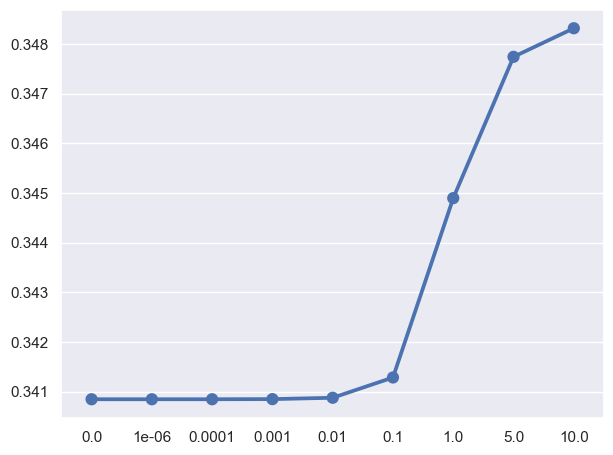

In [186]:
draw_r_vs_rmse(train_for_rs(X_train_0, y_train_0, X_val_0, y_val_0))

##### Which r gives the best RMSE?
* r=0

In [189]:
def split_data(df_local: pd.DataFrame, seed, val_percentage=0.2, test_percentage=0.2):
    n = len(df_local)
    n_val = int(n * val_percentage)
    n_test = int(n * test_percentage)
    n_train = n - n_val - n_test

    np.random.seed(seed)
    index_rand = np.arange(n)
    np.random.shuffle(index_rand)
    
    df_train = df_local.iloc[index_rand[:n_train]]
    df_val = df_local.iloc[index_rand[n_train:n_train+n_val]]
    df_test = df_local.iloc[index_rand[n_train+n_val:]]
    
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    return df_train, df_val, df_test

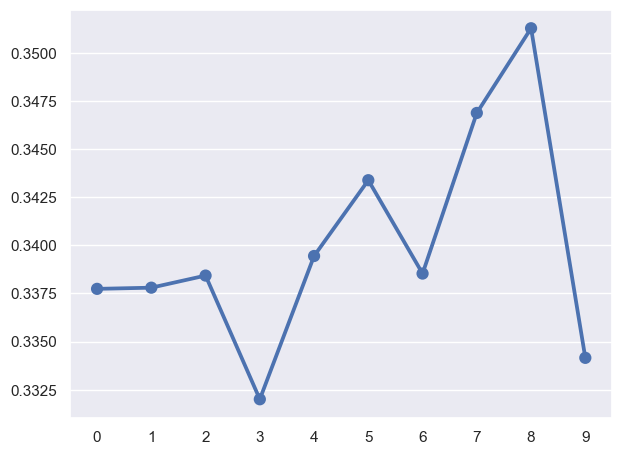

STD for rmse: 0.005


In [199]:
seed_results = []
for s in range(10):
    df_train, df_val, df_test = split_data(df_small, s)
    
    X_train_0, y_train_0 = prepare_data(df_train)
    X_val_0, y_val_0 = prepare_data(df_val)
    X_test_0, y_test_0 = prepare_data(df_test)
    
    w0_0, w_0 = train_linear_regression_reg(X_train_0, y_train_0)
    y_pred_0 = w0_0 + X_val_0.dot(w_0)
    
    seed_results.append((s, rmse(y_pred_0, y_val_0)))

r_s=[r[0] for r in seed_results]
rmse_s = [r[1] for r in seed_results]
sns.pointplot(x=r_s, y=rmse_s)
plt.show()

print(f"STD for rmse: {round(np.std(rmse_s), 3)}")

##### What's the standard deviation of all the scores?
* 0.005

In [202]:
s = 9
df_train, df_val, df_test = split_data(df_small, s)
    
X_train_0, y_train_0 = prepare_data(df_train)
X_val_0, y_val_0 = prepare_data(df_val)
X_test_0, y_test_0 = prepare_data(df_test)

w0_0, w_0 = train_linear_regression_reg(X_train_0, y_train_0, 0.001)
y_pred_0 = w0_0 + X_val_0.dot(w_0)

round(rmse(y_pred_0, y_val_0), 2)

0.33